# Data

In [1]:
import torchvision.transforms as T
import torchvision
import torch
from torch.utils.data import DataLoader

download_root = './MNIST_DATASET'

mnist_transform = T.Compose([
    T.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=False)
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=False) 

total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) 
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# Model

In [2]:
import torch
import torch.nn as nn
from  pytorch_lightning import LightningModule, Trainer 
import torch.optim as optim

In [10]:
class AutoEncoderLinear(LightningModule):
    def __init__(self, symetric_dimensions, lr):
        super().__init__()

        self.lr = lr
        self.criterion = nn.MSELoss()

        encoder_layer = []
        decoder_layer = []

        self.active = nn.ReLU()
        self.sig_act = nn.Sigmoid()
        
        for idx, dim in enumerate(symetric_dimensions[1:]):
            input = symetric_dimensions[idx]
            fc_layer = nn.Linear(input, dim)
            encoder_layer.append(fc_layer)
            encoder_layer.append(self.active)

        reverse_symetric_dimensions = symetric_dimensions[::-1]
        for idx, dim in enumerate(reverse_symetric_dimensions[1:]):
            input = reverse_symetric_dimensions[idx]
            fc_layer = nn.Linear(input, dim)
            decoder_layer.append(fc_layer)

            # 마지막 레이어는 sigmoid(0~1 값으로 출력하기 위해서)
            if idx == len(reverse_symetric_dimensions) - 2:
                decoder_layer.append(self.sig_act)
            else:
                decoder_layer.append(self.active)

        self.encoder = nn.Sequential(*encoder_layer)
        self.decoder = nn.Sequential(*decoder_layer)

    def forward(self, x) :
        '''
        INPUT
            x : [batch_size, 1, 28, 28]
        OUTPUT
            out : [batch_size, 28 * 28]
        '''
        x = x.view(x.size(0), -1) # [batch_size, 28 * 28]
        out = self.encoder(x)
        out = self.decoder(out)

        return out


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

    def training_step(self, batch):
        data, label = batch
        
        y = data.view(data.size(0), -1)
        y_hat = self(data)

        loss = self.criterion(y_hat, y)

        self.log(f"train_loss", loss, on_step=True, on_epoch=True, logger=True)

        return loss

    def validation_step(self, batch):
        data, label = batch
        
        y = data.view(data.size(0), -1)
        y_hat = self(data)

        loss = self.criterion(y_hat, y)

        self.log(f"valid_loss", loss, on_step=True, on_epoch=True, logger=True)

        return loss

    def test_step(self, batch):
        data, label = batch
        
        y = data.view(data.size(0), -1)
        y_hat = self(data)

        loss = self.criterion(y_hat, y)

        self.log(f"test_loss", loss, on_step=True, on_epoch=True, logger=True)

        return loss

    def predict_step(self, batch):
        data, label = batch
        
        y_hat = self(data)

        predict = y_hat.view(y_hat.size(0), 28, 28)

        return predict 

# Train & Test

In [11]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

symetric_dimensions = [784, 112, 56, 28]
model = AutoEncoderLinear(symetric_dimensions=symetric_dimensions, lr = 0.001)

early_stopping = EarlyStopping(monitor='valid_loss', mode='min', patience=5)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
wandb_logger = WandbLogger(name = 'AutoEncoderLinear')

trainer = Trainer(
    max_epochs = 50,
    accelerator = 'auto',
    callbacks= [ early_stopping, lr_monitor],
    logger = wandb_logger
)

trainer.fit(model, 
            train_dataloader,
            valid_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | criterion | MSELoss    | 0      | train
1 | active    | ReLU       | 0      | train
2 | sig_act   | Sigmoid    | 0      | train
3 | encoder   | Sequential | 95.8 K | train
4 | decoder   | Sequential | 96.6 K | train
-------------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.770     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
trainer.test(model, test_dataloader)

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.01180516928434372    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.01180516928434372}]

In [26]:
print(len(test_dataloader))
for batch, label in test_dataloader:
    print(batch.shape)
    break

313
torch.Size([32, 1, 28, 28])


In [29]:
prediction = trainer.predict(model, test_dataloader)
print(len(prediction))
print(prediction[0].shape)

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

313
torch.Size([32, 28, 28])


torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


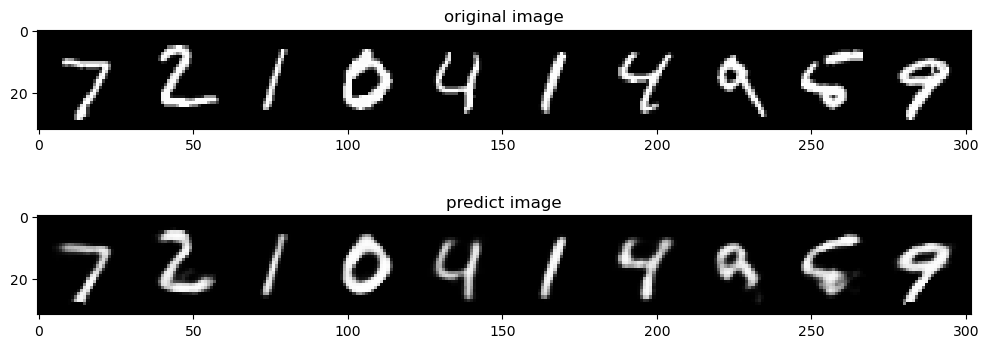

In [43]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images[:10]
pred_images = prediction[0][:10].unsqueeze(1)
print(pred_images.shape)
print(images.shape)

image_grid = vutils.make_grid(images, nrow = 10, padding = 2, normalize = True).numpy()
pred_image_grid = vutils.make_grid(pred_images, nrow = 10, padding = 2, normalize = True).numpy()

image_grid = image_grid.transpose((1, 2, 0))
pred_image_grid = pred_image_grid.transpose((1, 2, 0))

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.title("original image")
plt.imshow(image_grid)

plt.subplot(2, 1, 2)
plt.title("predict image")
plt.imshow(pred_image_grid)

plt.tight_layout()
plt.show()

In [46]:
for batch in test_dataloader:
    predicts = model.predict_step(batch)
    print(predicts.shape)
    break

torch.Size([32, 28, 28])
